# Grid Detection Visualizer

This notebook demonstrates the step-by-step process of detecting grid lines in a shuffled image using gradient analysis. We will visualize the gradients, the 1D profiles, and how the algorithm decides on the grid size.

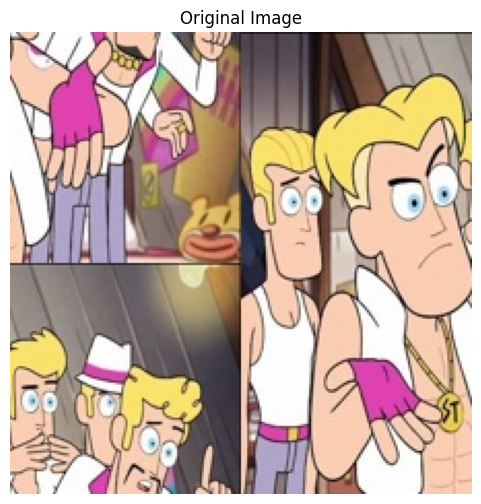

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import cv2
from image_utils import load_image, compute_spatial_energy, evaluate_partition_score, detect_grid_size

%matplotlib inline

# Path to the image we want to analyze
image_path = "./Gravity Falls/puzzle_2x2/80.jpg" 

# Load and display the original image
img = load_image(image_path)

if img is not None:
    plt.figure(figsize=(6, 6))
    plt.imshow(img)
    plt.title("Original Image")
    plt.axis('off')
    plt.show()
else:
    print("Failed to load image.")

## 1. Convert to Grayscale

We convert the image to grayscale to simplify the analysis. We only care about the intensity changes (edges), not the colors.

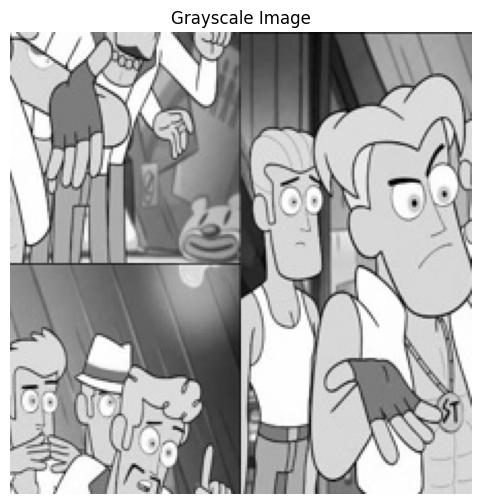

In [2]:
# Convert to grayscale using OpenCV
img_bgr = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
gray = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2GRAY)

plt.figure(figsize=(6, 6))
plt.imshow(gray, cmap='gray')
plt.title("Grayscale Image")
plt.axis('off')
plt.show()

## 2. Compute Spatial Energy Profiles

The new algorithm uses Sobel gradients to compute energy profiles:
*   **Energy X**: Sum of vertical gradients (detects vertical boundaries) - profile along X-axis
*   **Energy Y**: Sum of horizontal gradients (detects horizontal boundaries) - profile along Y-axis

Higher energy = stronger boundary at that position.

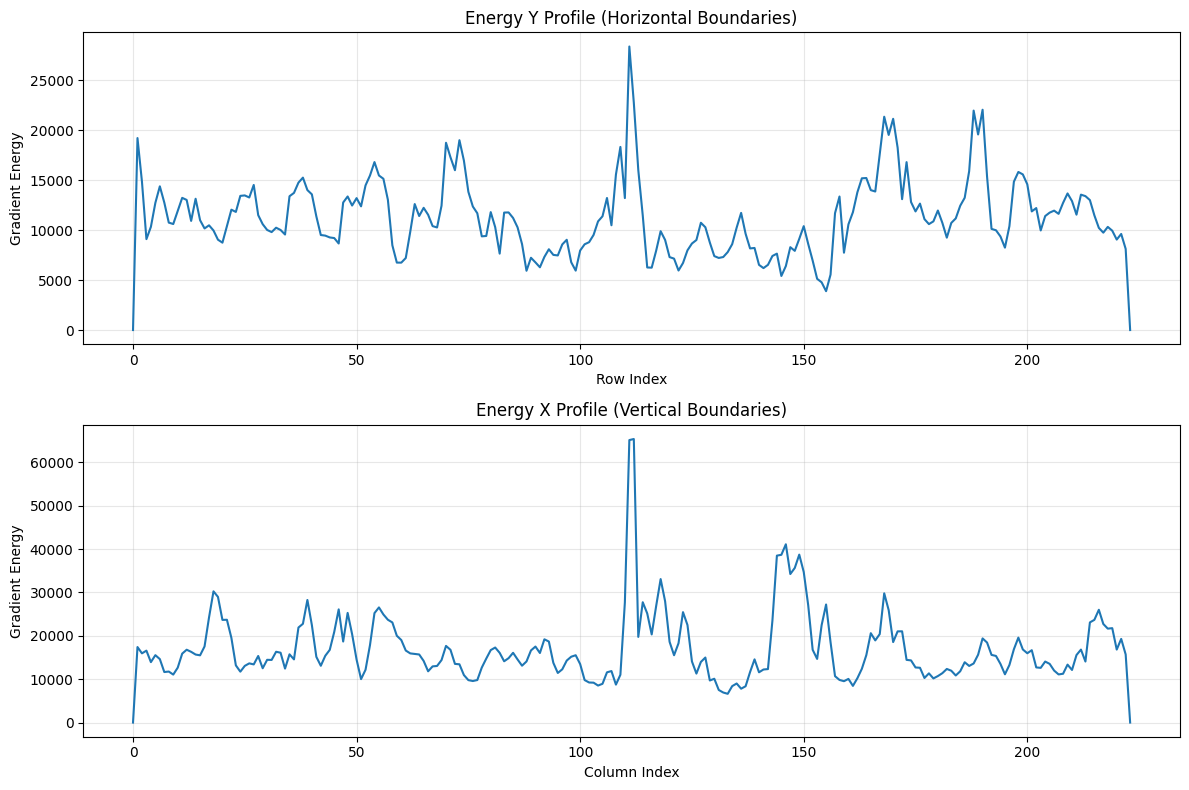

Max Energy X (vertical boundaries): 65370.00
Max Energy Y (horizontal boundaries): 28382.00


In [3]:
# Compute spatial energy profiles using the same method as detect_grid_size
H, W = gray.shape

# Compute energy profiles
energy_x = compute_spatial_energy(gray, axis_orientation=0)  # Vertical boundaries
energy_y = compute_spatial_energy(gray, axis_orientation=1)  # Horizontal boundaries

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 8))

ax1.plot(energy_y)
ax1.set_title("Energy Y Profile (Horizontal Boundaries)")
ax1.set_xlabel("Row Index")
ax1.set_ylabel("Gradient Energy")
ax1.grid(True, alpha=0.3)

ax2.plot(energy_x)
ax2.set_title("Energy X Profile (Vertical Boundaries)")
ax2.set_xlabel("Column Index")
ax2.set_ylabel("Gradient Energy")
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Get max energies for normalization
max_energy_x = np.max(energy_x)
max_energy_y = np.max(energy_y)

print(f"Max Energy X (vertical boundaries): {max_energy_x:.2f}")
print(f"Max Energy Y (horizontal boundaries): {max_energy_y:.2f}")

## 3. Evaluate Partition Scores

The algorithm checks ODD-numbered divisions (1/N, 3/N, 5/N...) to avoid counting shared boundaries:
- For 8x8: checks positions 1/8, 3/8, 5/8, 7/8 (avoids 1/2 which exists in 2x2)
- For 4x4: checks positions 1/4, 3/4 (avoids 1/2 which exists in 2x2)

This ensures a 2x2 grid isn't mistaken for 4x4 or 8x8.

In [4]:
# Evaluate scores for each hypothesis
score_X4 = evaluate_partition_score(energy_x, W, 4)
score_Y4 = evaluate_partition_score(energy_y, H, 4)

score_X8 = evaluate_partition_score(energy_x, W, 8)
score_Y8 = evaluate_partition_score(energy_y, H, 8)

print("=== Partition Scores ===")
print(f"4x4 - Energy X: {score_X4:.2f}, Energy Y: {score_Y4:.2f}")
print(f"8x8 - Energy X: {score_X8:.2f}, Energy Y: {score_Y8:.2f}")
print()

# Calculate relative strengths (compared to max energy)
rel_X4 = score_X4 / max_energy_x if max_energy_x > 0 else 0
rel_Y4 = score_Y4 / max_energy_y if max_energy_y > 0 else 0
rel_X8 = score_X8 / max_energy_x if max_energy_x > 0 else 0
rel_Y8 = score_Y8 / max_energy_y if max_energy_y > 0 else 0

print("=== Relative Strengths (score / max_energy) ===")
print(f"4x4 - X: {rel_X4:.3f}, Y: {rel_Y4:.3f}")
print(f"8x8 - X: {rel_X8:.3f}, Y: {rel_Y8:.3f}")

=== Partition Scores ===
4x4 - Energy X: 28167.50, Energy Y: 19084.00
8x8 - Energy X: 22919.75, Energy Y: 13470.00

=== Relative Strengths (score / max_energy) ===
4x4 - X: 0.431, Y: 0.672
8x8 - X: 0.351, Y: 0.475


## 4. Visualize Detection Points

Let's visualize where the algorithm checks for boundaries and mark the expected positions.

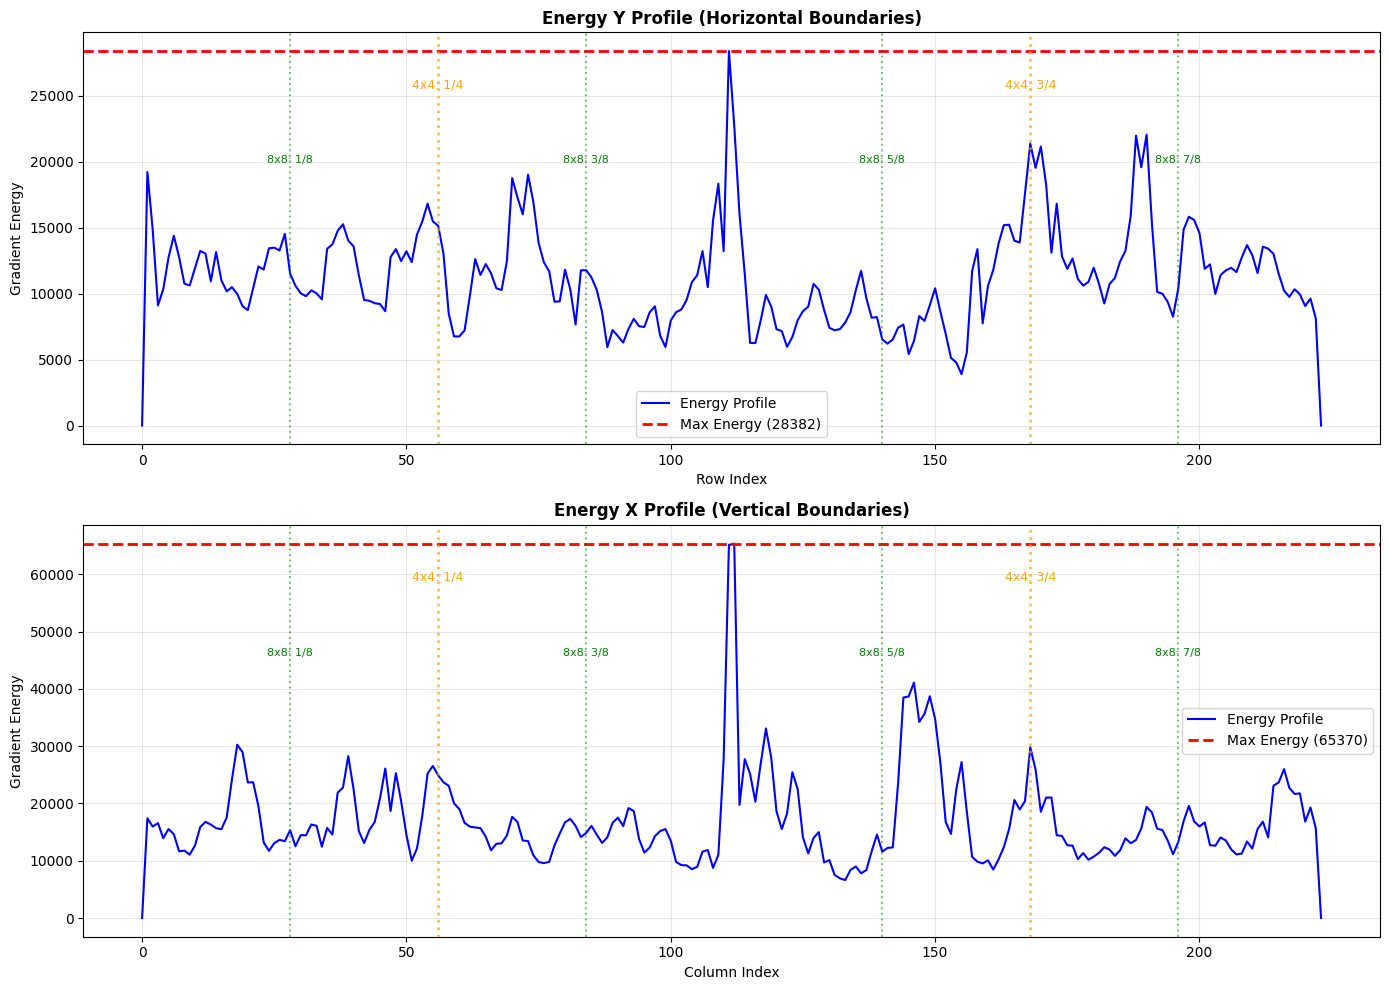

In [5]:
# Visualize the energy profiles with detection points
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 10))

# Energy Y (horizontal boundaries)
ax1.plot(energy_y, 'b-', linewidth=1.5, label='Energy Profile')
ax1.axhline(max_energy_y, color='red', linestyle='--', linewidth=2, label=f'Max Energy ({max_energy_y:.0f})')

# Mark 4x4 check points (1/4, 3/4)
for i in [1, 3]:
    pos = int((H / 4) * i)
    ax1.axvline(pos, color='orange', linestyle=':', alpha=0.7, linewidth=2)
    ax1.text(pos, max_energy_y * 0.9, f'4x4: {i}/4', color='orange', ha='center', fontsize=9)

# Mark 8x8 check points (1/8, 3/8, 5/8, 7/8)
for i in [1, 3, 5, 7]:
    pos = int((H / 8) * i)
    ax1.axvline(pos, color='green', linestyle=':', alpha=0.5, linewidth=1.5)
    ax1.text(pos, max_energy_y * 0.7, f'8x8: {i}/8', color='green', ha='center', fontsize=8)

ax1.set_title("Energy Y Profile (Horizontal Boundaries)", fontsize=12, fontweight='bold')
ax1.set_xlabel("Row Index")
ax1.set_ylabel("Gradient Energy")
ax1.legend()
ax1.grid(True, alpha=0.3)

# Energy X (vertical boundaries)
ax2.plot(energy_x, 'b-', linewidth=1.5, label='Energy Profile')
ax2.axhline(max_energy_x, color='red', linestyle='--', linewidth=2, label=f'Max Energy ({max_energy_x:.0f})')

# Mark 4x4 check points
for i in [1, 3]:
    pos = int((W / 4) * i)
    ax2.axvline(pos, color='orange', linestyle=':', alpha=0.7, linewidth=2)
    ax2.text(pos, max_energy_x * 0.9, f'4x4: {i}/4', color='orange', ha='center', fontsize=9)

# Mark 8x8 check points
for i in [1, 3, 5, 7]:
    pos = int((W / 8) * i)
    ax2.axvline(pos, color='green', linestyle=':', alpha=0.5, linewidth=1.5)
    ax2.text(pos, max_energy_x * 0.7, f'8x8: {i}/8', color='green', ha='center', fontsize=8)

ax2.set_title("Energy X Profile (Vertical Boundaries)", fontsize=12, fontweight='bold')
ax2.set_xlabel("Column Index")
ax2.set_ylabel("Gradient Energy")
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 5. Final Decision Using Relative Strength Thresholds

The algorithm uses **relative strength** to make the decision:
- The finer grid lines (4x4 or 8x8) must be at least X% as strong as the maximum energy
- This ensures we only detect finer grids when the additional boundaries are prominent enough

Thresholds:
- REL_STRENGTH_8 = 0.52 (52% of max energy)
- REL_STRENGTH_4 = 0.53 (53% of max energy)

In [6]:
REL_STRENGTH_8 = 0.52
REL_STRENGTH_4 = 0.53

# Check 8x8
confirmed_X8 = (rel_X8 > REL_STRENGTH_8)
confirmed_Y8 = (rel_Y8 > REL_STRENGTH_8)

# Check 4x4
confirmed_X4 = (rel_X4 > REL_STRENGTH_4)
confirmed_Y4 = (rel_Y4 > REL_STRENGTH_4)

print("=== Threshold Checks ===")
print(f"8x8 Thresholds (need > {REL_STRENGTH_8}):")
print(f"  X: {rel_X8:.3f} {'✓ PASS' if confirmed_X8 else '✗ FAIL'}")
print(f"  Y: {rel_Y8:.3f} {'✓ PASS' if confirmed_Y8 else '✗ FAIL'}")
print(f"  Both: {'✓ CONFIRMED 8x8' if (confirmed_X8 and confirmed_Y8) else '✗ Not 8x8'}")
print()

print(f"4x4 Thresholds (need > {REL_STRENGTH_4}):")
print(f"  X: {rel_X4:.3f} {'✓ PASS' if confirmed_X4 else '✗ FAIL'}")
print(f"  Y: {rel_Y4:.3f} {'✓ PASS' if confirmed_Y4 else '✗ FAIL'}")
print(f"  Both: {'✓ CONFIRMED 4x4' if (confirmed_X4 and confirmed_Y4) else '✗ Not 4x4'}")
print()

# Final decision (hierarchical)
detected_size = None
if confirmed_X8 and confirmed_Y8:
    detected_size = 8
elif confirmed_X4 and confirmed_Y4:
    detected_size = 4
else:
    detected_size = 2

print("="*50)
print(f"🎯 FINAL DETECTED GRID SIZE: {detected_size}x{detected_size}")
print("="*50)

# Verify with actual function
actual_detected = detect_grid_size(image_path)
print(f"\n✓ Verification: detect_grid_size() returned {actual_detected}x{actual_detected}")

=== Threshold Checks ===
8x8 Thresholds (need > 0.52):
  X: 0.351 ✗ FAIL
  Y: 0.475 ✗ FAIL
  Both: ✗ Not 8x8

4x4 Thresholds (need > 0.53):
  X: 0.431 ✗ FAIL
  Y: 0.672 ✓ PASS
  Both: ✗ Not 4x4

🎯 FINAL DETECTED GRID SIZE: 2x2

✓ Verification: detect_grid_size() returned 2x2
